# Analysis

In [1]:
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt

### Settings

In [2]:
# Set core metrics
core_metrics = ['fks', 'vader', 'subj', 'liwc']

### Loading 

In [3]:
# Set path to load files from
res_path = '/Users/tom/Documents/GitCode/Confidence_Scanner/scripts/results/'
#res_path = '/Users/wdfox/Documents/GitCode/Confidence_Scanner/scripts/results/'

In [4]:
# Load files
dfs = []
for dat_type in ['Papers', 'PRs']:
    
    d1 = pd.read_csv(os.path.join(res_path, dat_type + '_readability.csv'))
    d2 = pd.read_csv(os.path.join(res_path, dat_type + '_analysis.csv'))
    d3 = pd.read_csv(os.path.join(res_path, dat_type + '_metadata.csv'))
    
    # Merge dataframes - to get all features for particular document type
    dft = pd.merge(d1, d2, on=['id', 'term'])
    df = pd.merge(dft, d3, on=['id', 'term'])
    df['dat_type'] = dat_type
    
    dfs.append(df)

In [5]:
# Combine into one joint df, with all data (papers and press releases)
df = pd.concat(dfs)

In [6]:
## Cleans ups
df.set_index('id', inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

# Drop old data columns (remove when analysis re-run)
df = df.drop(['fk', 'consen'], axis=1)

In [7]:
# Drop any documents which have zero words
df = df[df['n_words'] > 0]

In [8]:
# Test: Drop any documents which have zero scores on subjectivity / sentiment
#df = df[df['liwc'] != 0]
#df = df[df['subj'] != 0]

In [9]:
# Check out a few rows
df.head()

,term,smog,ar,fkg,fks,lwf,vader,liu,subj,liwc,n_words,n_sentences,has_source_link,has_article_link,has_other_link,region,journal,dat_type
id,,,,,,,,,,,,,,,,,,
29373119,autism,16.6,18.2,15.2,18.86,7.500000,1.0194,-1.0,3.0,6.0,143,9,NaN,NaN,NaN,NaN,Biological psychiatry,Papers
29369294,autism,18.2,22.2,17.7,12.46,7.916667,-2.5924,-2.0,5.0,6.0,189,11,NaN,NaN,NaN,NaN,Acta neurobiologiae experimentalis,Papers
29367178,autism,15.1,14.8,13.1,35.07,7.000000,0.9111,2.0,-2.0,8.0,125,8,NaN,NaN,NaN,NaN,Epilepsy research,Papers
29361396,autism,21.3,23.7,19.8,12.30,18.000000,-0.9329,-3.0,0.0,0.0,116,6,NaN,NaN,NaN,NaN,Neuromuscular disorders : NMD,Papers
29358944,autism,17.3,18.5,16.5,21.02,13.125000,0.0173,1.0,-1.0,6.0,101,7,NaN,NaN,NaN,NaN,Frontiers in genetics,Papers


### Clean Ups & Control for document length

Optional analysis in which relevant measures are normalized by word length

In [10]:
# Normalize relevant measures
df['liwc'] = df['liwc'] / df['n_words']
df['subj'] = df['subj'] / df['n_sentences']

In [11]:
# Remove outliers
n_before = len(df)
for metric in core_metrics:
    std3 = 3 * df[metric].std()
    std_max = df[metric].mean() + std3
    std_min = df[metric].mean() - std3

    df = df[df[metric] > std_min]
    df = df[df[metric] < std_max]
n_after = len(df)

print(n_before - n_after, 'data points dropped.')

533 data points dropped.


### Explore

In [12]:
# Check how many there are of each data type
df['dat_type'].value_counts()

Papers    9754
PRs       5284
Name: dat_type, dtype: int64

In [13]:
# Check how many documents there are for each term
df['term'].value_counts()

diabetes         2438
stroke           1909
perception       1604
vaccines         1386
dementia         1278
cognition        1265
autism           1235
hypertension     1212
epilepsy         1058
consciousness    1006
optogenetics      647
Name: term, dtype: int64

In [14]:
# Check how many of each document there are, split up by document type and term
df.groupby(['dat_type', 'term']).size()

dat_type  term         
PRs       autism            300
          cognition         315
          consciousness      73
          dementia          364
          diabetes         1577
          epilepsy          194
          hypertension      318
          optogenetics       52
          perception        646
          stroke           1011
          vaccines          434
Papers    autism            935
          cognition         950
          consciousness     933
          dementia          914
          diabetes          861
          epilepsy          864
          hypertension      894
          optogenetics      595
          perception        958
          stroke            898
          vaccines          952
dtype: int64

In [15]:
# Descriptive statistics
df.describe()

,smog,ar,fkg,fks,lwf,vader,liu,subj,liwc,n_words,n_sentences,has_source_link,has_article_link,has_other_link
count,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,5284.000000,5284.000000,5284.000000
mean,15.346476,17.030303,13.936807,33.329688,11.153216,0.605715,-0.478189,-0.155183,0.017368,200.636920,12.408964,0.357684,0.449659,0.035201
std,2.328123,3.156361,2.742177,13.779350,3.805077,2.242387,4.206437,0.415520,0.027538,136.793154,7.908639,0.479364,0.497506,0.184304
min,0.000000,5.700000,4.200000,-9.540000,1.500000,-7.327000,-25.000000,-1.666667,-0.071429,3.000000,1.000000,0.000000,0.000000,0.000000
25%,14.000000,15.000000,12.200000,24.210000,8.200000,-0.652275,-3.000000,-0.428571,0.000000,115.000000,7.000000,0.000000,0.000000,0.000000
50%,15.300000,17.000000,13.900000,34.190000,10.900000,0.533100,0.000000,-0.142857,0.015203,149.000000,10.000000,0.000000,0.000000,0.000000
75%,16.800000,19.000000,15.700000,42.950000,13.250000,1.779750,2.000000,0.111111,0.033898,262.000000,15.000000,1.000000,1.000000,0.000000
max,26.200000,37.600000,30.900000,75.910000,55.500000,8.617400,20.000000,1.333333,0.108108,2310.000000,102.000000,1.000000,1.000000,1.000000


In [16]:
# Check out the descriptive statistics separated out by dat_type
pd.set_option('display.max_columns', 100)
df.groupby(['dat_type']).describe()

ar                                                       fkg  \
           count       mean       std  min   25%   50%   75%   max   count   
dat_type                                                                     
PRs       5284.0  16.802309  2.347940  8.3  15.2  16.6  18.3  28.3  5284.0   
Papers    9754.0  17.153814  3.511492  5.7  14.8  17.2  19.4  37.6  9754.0   

                                                               fks             \
               mean       std  min   25%   50%   75%   max   count       mean   
dat_type                                                                        
PRs       13.657721  1.988143  6.5  12.3  13.5  14.9  23.4  5284.0  39.830131   
Papers    14.087995  3.063874  4.2  12.0  14.2  16.2  30.9  9754.0  29.808226   

                                                        has_article_link  \
                std   min      25%    50%    75%    max            count   
dat_type                                                                   
PRs        9.572742 -1.55  33.6425  40.28  46.91  74.73           5284.0   
Papers    14.415458 -9.54  19.9700  29.59  39.37  75.91              0.0   

                                                      has_other_link  \
              mean       std  min  25%  50%  75%  max          count   
dat_type                                                               
PRs       0.449659  0.497506  0.0  0.0  0.0  1.0  1.0         5284.0   
Papers         NaN       NaN  NaN  NaN  NaN  NaN  NaN            0.0   

                                                      has_source_link  \
              mean       std  min  25%  50%  75%  max           count   
dat_type                                                                
PRs       0.035201  0.184304  0.0  0.0  0.0  0.0  1.0          5284.0   
Papers         NaN       NaN  NaN  NaN  NaN  NaN  NaN             0.0   

                                                          liu            \
              mean       std  min  25%  50%  75%  max   count      mean   
dat_type                                                                  
PRs       0.357684  0.479364  0.0  0.0  0.0  1.0  1.0  5284.0 -0.470855   
Papers         NaN       NaN  NaN  NaN  NaN  NaN  NaN  9754.0 -0.482161   

           ...        liwc               lwf                                  \
           ...         75%       max   count      mean       std  min    25%   
dat_type   ...                                                                 
PRs        ...    0.027615  0.107955  5284.0  12.64134  4.033290  3.7  10.20   
Papers     ...    0.036799  0.108108  9754.0  10.34706  3.414878  1.5   7.75   

                             n_sentences                                  \
           50%    75%    max       count       mean       std  min   25%   
dat_type                                                                   
PRs       12.5  14.75  30.25      5284.0  19.345193  9.194456  2.0  13.0   
Papers    10.4  12.50  55.50      9754.0   8.651425  3.233312  1.0   6.0   

                            n_words                                       \
           50%   75%    max   count        mean         std   min    25%   
dat_type                                                                   
PRs       18.0  24.0  102.0  5284.0  335.330053  145.986151  41.0  246.0   
Papers     8.0  11.0   43.0  9754.0  127.670084   46.392857   3.0   99.0   

                                  smog                                        \
            50%    75%     max   count       mean       std  min   25%   50%   
dat_type                                                                       
PRs       314.0  401.0  2310.0  5284.0  15.015424  1.571801  9.5  14.0  14.9   
Papers    126.0  149.0  1095.0  9754.0  15.525815  2.631902  0.0  13.9  15.7   

                        subj                                          \
           75%   max   count      mean       std       min       25%   
dat_type                 

## PR specific Stuff

In [17]:
# Check documents by region (PR only)
df['region'].value_counts()

namerica     3976
europe       1045
asia          159
australia      42
africa         32
samerica       16
Name: region, dtype: int64

In [18]:
# Check how many have links
print('Article Link: ', '\t', df['has_article_link'].mean())
print('Source Link: ', '\t', df['has_source_link'].mean())
print('Other Link: ', '\t', df['has_other_link'].mean())

Article Link:  	 0.44965934897804694
Source Link:  	 0.35768357305071913
Other Link:  	 0.03520060560181681


## Analyses

In [19]:
# Check correlation between metrics
corrs = df[core_metrics].corr()
corrs

,fks,vader,subj,liwc
fks,1.000000,0.021092,-0.071276,-0.005760
vader,0.021092,1.000000,0.043149,0.048979
subj,-0.071276,0.043149,1.000000,-0.080948
liwc,-0.005760,0.048979,-0.080948,1.000000


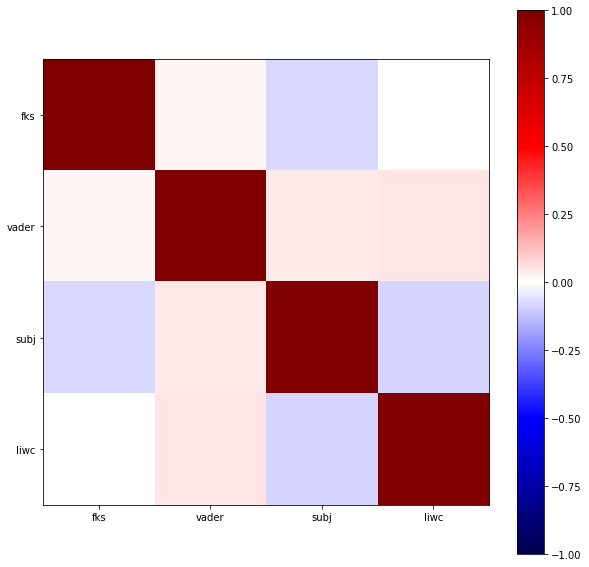

In [20]:
# Plot the correlation matrix
plt.figure(figsize=[10, 10])
plt.imshow(corrs.values, cmap='seismic', vmin=-1, vmax=1);
plt.xticks(range(len(corrs)), list(corrs.columns));
plt.yticks(range(len(corrs)), list(corrs.columns));
plt.colorbar()

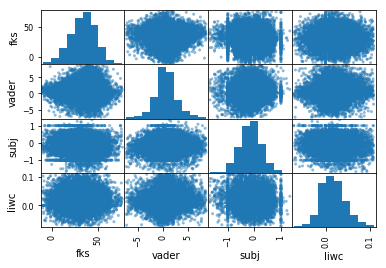

In [21]:
# Plot relations between metrics
pd.plotting.scatter_matrix(df[core_metrics]);

In [22]:
# Check the average scores for each measure across different terms
avgs = df.groupby(['term', 'dat_type'])[core_metrics].mean()
avgs

fks     vader      subj      liwc
term          dat_type                                         
autism        PRs       38.924267  1.607602 -0.200341  0.016562
              Papers    26.844481  0.220525 -0.079435  0.019736
cognition     PRs       39.298667  2.038646 -0.143236  0.013240
              Papers    26.123895  0.495742 -0.048327  0.017531
consciousness PRs       39.270685  0.392077 -0.213236  0.013803
              Papers    29.824523 -0.076349 -0.105893  0.016039
dementia      PRs       38.976813  1.096778 -0.213012  0.015526
              Papers    29.235864  0.428008 -0.105786  0.017758
diabetes      PRs       39.484331  1.064744 -0.251946  0.016856
              Papers    33.810035  0.341357 -0.178264  0.022341
epilepsy      PRs       42.172577  1.181319 -0.164275  0.016033
              Papers    31.492222  0.276669 -0.126539  0.017570
hypertension  PRs       38.206635  0.211864 -0.240183  0.016607
              Papers    34.049105  0.035265 -0.185576  0.020806
optogenetics  PRs       39.173462  2.343277 -0.184422  0.015611
              Papers    18.060790  0.624831 -0.030396  0.017651
perception    PRs       40.246981  1.791407 -0.136525  0.008403
              Papers    29.830678  0.621311 -0.096467  0.018269
stroke        PRs       40.723432  0.431940 -0.223661  0.014871
              Papers    35.961292  0.054763 -0.191789  0.021203
vaccines      PRs       40.428088  1.434572 -0.295432  0.016331
              Papers    29.314569  0.698146 -0.158097  0.016474

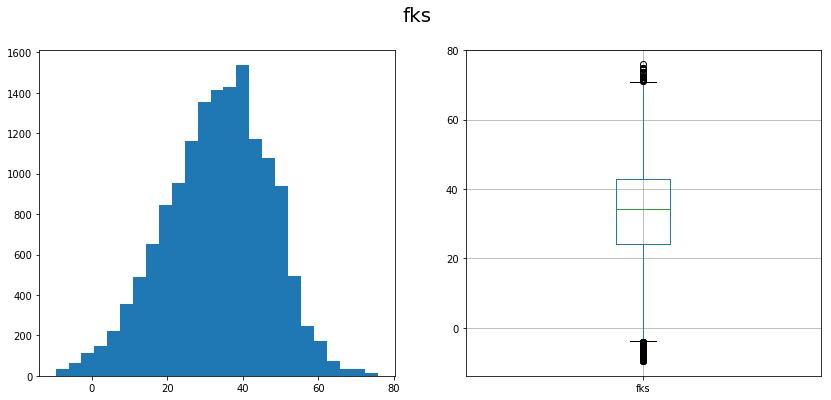

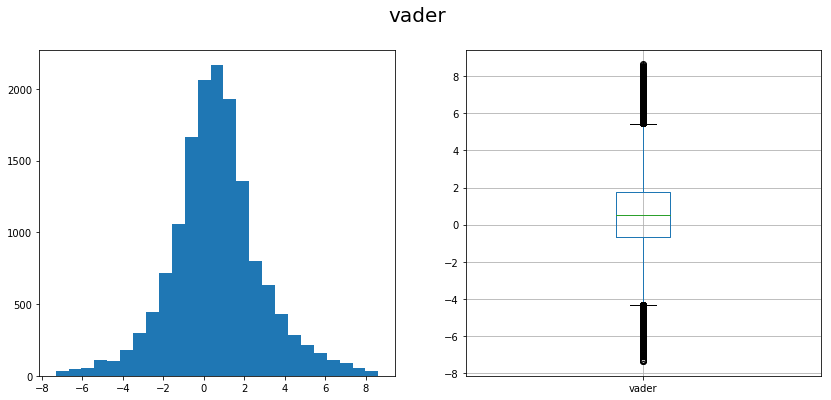

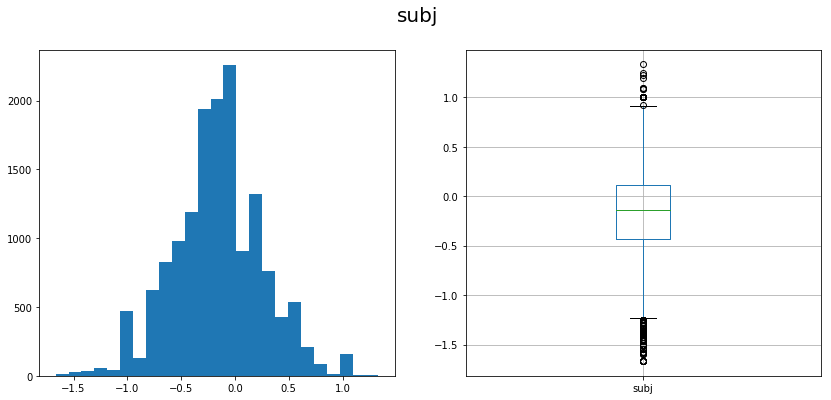

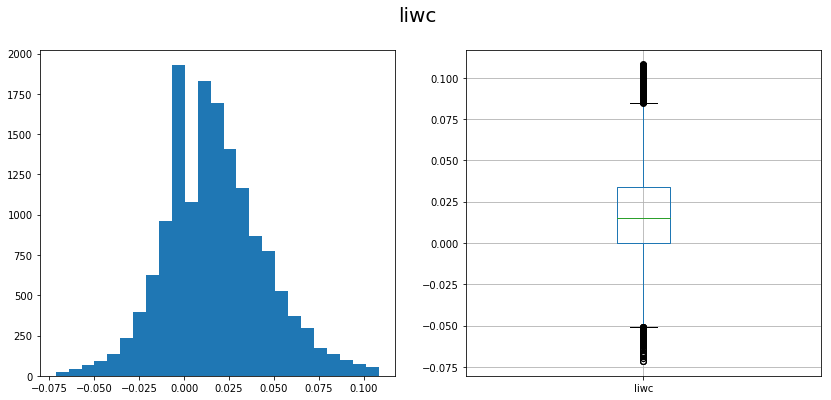

In [23]:
# Plot measures, collapsed across data type
#for metric in ['fkg', 'fks', 'smog', 'ar', 'lwf', 'vader', 'liu', 'subj', 'liwc']:
for metric in core_metrics:
    fig, ax = plt.subplots(1, 2, figsize=[14, 6])
    ax[0].hist(df[metric], bins=25);
    pd.plotting.boxplot(df, metric, ax=ax[1]);
    plt.suptitle(metric, fontsize=20)

In [24]:
# Check the average differences between data types
df.groupby('dat_type')[core_metrics].mean()

,fks,vader,subj,liwc
dat_type,,,,
PRs,39.830131,1.110210,-0.218776,0.014976
Papers,29.808226,0.332417,-0.120732,0.018664


/Users/tom/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


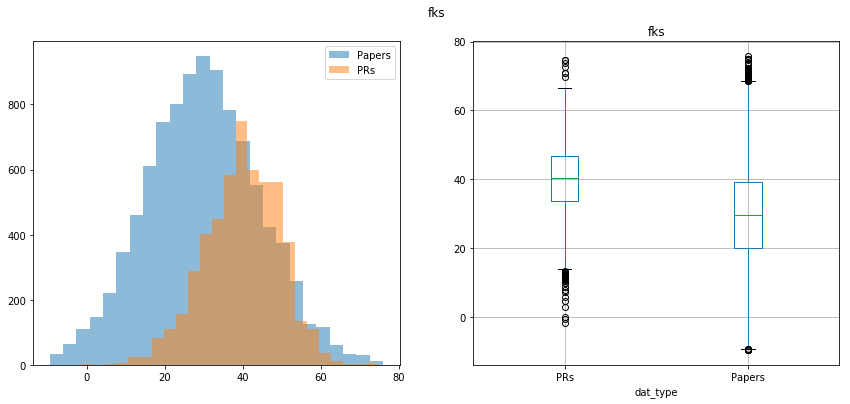

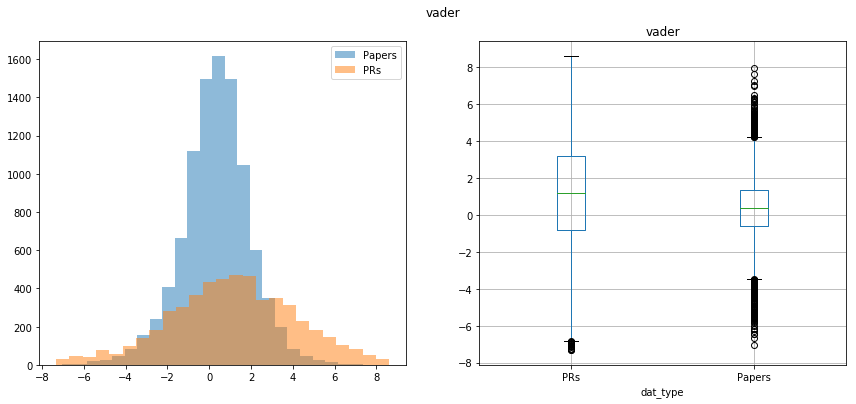

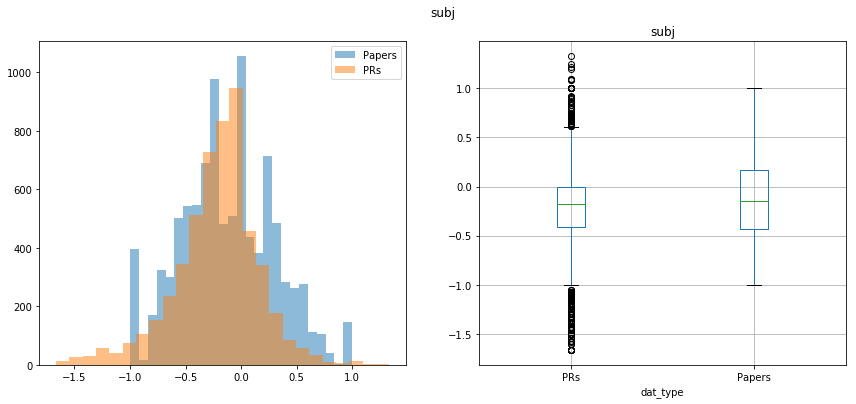

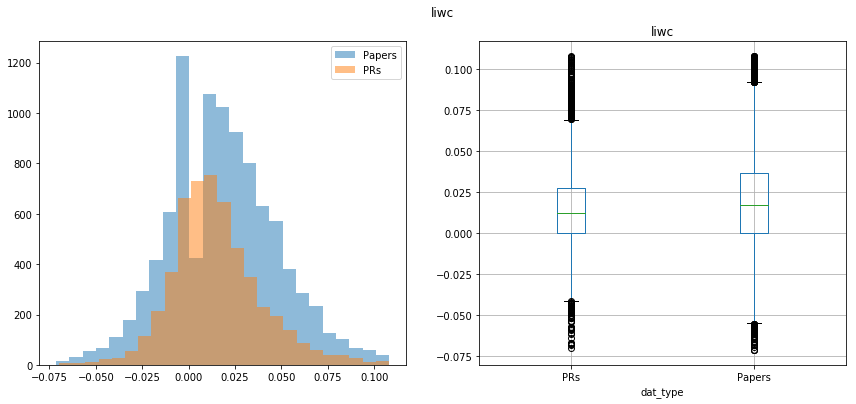

In [25]:
# Plot measures, separated by data type
#for metric in ['fkg', 'fks', 'smog', 'ar', 'lwf', 'vader', 'liu', 'subj', 'liwc']:
for metric in core_metrics:
    fig, ax = plt.subplots(1, 2, figsize=[14, 6])
    
    
    ax[0].hist(df[df.dat_type == 'Papers'][metric], bins=25, alpha=0.5, label='Papers');
    ax[0].hist(df[df.dat_type == 'PRs'][metric], bins=25, alpha=0.5, label='PRs');
    ax[0].legend()
    
    pd.plotting.boxplot(df, metric, 'dat_type', ax=ax[1])
    
    plt.suptitle(metric)

# STATISTICS!

In [26]:
from statistics import mean, stdev
from math import sqrt

from scipy.stats import ttest_ind
from scipy import stats

In [27]:
# Define Cohen's D
def cohens_d(d1, d2):
    return (mean(d1) - mean(d2)) / (sqrt((stdev(d1) ** 2 + stdev(d2) ** 2) / 2))

In [28]:
#
#for metric in ['fkg', 'fks', 'smog', 'ar', 'lwf', 'vader', 'liu', 'subj', 'liwc']:
for metric in core_metrics:
    print(metric, '\t', ttest_ind(df[df.dat_type == 'Papers'][metric], df[df.dat_type == 'PRs'][metric]))

fks 	 Ttest_indResult(statistic=-45.402946718002639, pvalue=0.0)
vader 	 Ttest_indResult(statistic=-20.589917699880591, pvalue=6.438596406069839e-93)
subj 	 Ttest_indResult(statistic=13.901636456943166, pvalue=1.1532388195201792e-43)
liwc 	 Ttest_indResult(statistic=7.8555148197222495, pvalue=4.2494618497655386e-15)


In [29]:
#
#for metric in ['fkg', 'fks', 'smog', 'ar', 'lwf', 'vader', 'liu', 'subj', 'liwc']:
for metric in core_metrics:
    print(metric, '\t', cohens_d(df[df.dat_type == 'Papers'][metric], df[df.dat_type == 'PRs'][metric]))

fks 	 -0.819045990249
vader 	 -0.321870635375
subj 	 0.241694084337
liwc 	 0.137638808013


In [30]:
# Check direction of effects
df.groupby('dat_type')[core_metrics].describe()

fks                                                            \
           count       mean        std   min      25%    50%    75%    max   
dat_type                                                                     
PRs       5284.0  39.830131   9.572742 -1.55  33.6425  40.28  46.91  74.73   
Papers    9754.0  29.808226  14.415458 -9.54  19.9700  29.59  39.37  75.91   

           vader                                                        \
           count      mean       std    min       25%     50%      75%   
dat_type                                                                 
PRs       5284.0  1.110210  3.005047 -7.327 -0.827800  1.1704  3.18305   
Papers    9754.0  0.332417  1.627396 -7.029 -0.606975  0.3890  1.31930   

                    subj                                                    \
             max   count      mean       std       min       25%       50%   
dat_type                                                                     
PRs       8.6174  5284.0 -0.218776  0.380307 -1.666667 -0.409759 -0.181818   
Papers    7.9335  9754.0 -0.120732  0.429507 -1.000000 -0.428571 -0.142857   

                                liwc                                     \
               75%       max   count      mean       std       min  25%   
dat_type                                                                  
PRs       0.000000  1.333333  5284.0  0.014976  0.024328 -0.069930  0.0   
Papers    0.166667  1.000000  9754.0  0.018664  0.029049 -0.071429  0.0   

                                        
               50%       75%       max  
dat_type                                
PRs       0.012422  0.027615  0.107955  
Papers    0.017351  0.036799  0.108108

## ANOVA (?)

Maybe something to do. MESSY EXPLORATIONS.

In [31]:
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

/Users/tom/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [32]:
df.columns

Index(['term', 'smog', 'ar', 'fkg', 'fks', 'lwf', 'vader', 'liu', 'subj',
       'liwc', 'n_words', 'n_sentences', 'has_source_link', 'has_article_link',
       'has_other_link', 'region', 'journal', 'dat_type'],
      dtype='object')

In [33]:
#lm = ols('liwc ~ dat_type + n_words', data=df).fit()
lm = ols('liwc ~ subj + vader + fks + n_words + dat_type', data=df).fit()
table = sm.stats.anova_lm(lm, typ=2)

In [34]:
table

,sum_sq,df,F,PR(>F)
dat_type,0.000779,1.0,1.049756,3.055797e-01
subj,0.083318,1.0,112.347646,3.708673e-26
vader,0.052319,1.0,70.547626,4.890697e-17
fks,0.005077,1.0,6.845447,8.895632e-03
n_words,0.066074,1.0,89.094878,4.304742e-21
Residual,11.147860,15032.0,NaN,NaN


In [35]:
# compute one-way ANOVA P value   
from scipy import stats  
      
f_val, p_val = stats.f_oneway(df[df.dat_type == 'Papers']['liwc'].values,
                              df[df.dat_type == 'PRs']['liwc'].values)
